Programmer: Chris Heise (crheise@icloud.com)
School: New Mexico Highlands University
Course: BSSD 3850 Data Modeling
Instructor: Jonathan Lee
Date: 1 December 2022

Program: Final Project
Purpose: using a Conditional GAN for image-to-image translation.

# CH-BSSD3850-Final

## Sources

### pix2pix: Image-to-Image Translation with a Conditional GAN
    - URL: https://www.tensorflow.org/tutorials/generative/pix2pix

### CycleGAN
    - URL: https://www.tensorflow.org/tutorials/generative/cyclegan

### Stanford Dog dataset
    - URL: http://vision.stanford.edu/aditya86/ImageNetDogs/
    - Primary: Aditya Khosla, Nityananda Jayadevaprakash, Bangpeng Yao and Li Fei-Fei. Novel dataset for Fine-Grained Image Categorization. First Workshop on Fine-Grained Visual Categorization (FGVC), IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2011.
    - Secondary: J. Deng, W. Dong, R. Socher, L.-J. Li, K. Li and L. Fei-Fei, ImageNet: A Large-Scale Hierarchical Image Database. IEEE Computer Vision and Pattern Recognition (CVPR), 2009.
    - Changelog: Did not include Annotations folder and only included Image Folders for Beagles and Malamutes.

In [18]:
%pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /private/var/folders/f5/s00w_f497nsg2mvwljfcdrqh0000gn/T/pip-req-build-wjdowrkb
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /private/var/folders/f5/s00w_f497nsg2mvwljfcdrqh0000gn/T/pip-req-build-wjdowrkb
  Resolved https://github.com/tensorflow/examples.git to commit a55d94841a9cbf7b3b77d35bf81189fc6010dcc5
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [19]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

from ipywidgets import widgets

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

# Random Jitter
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

# Generators & Discriminators
OUTPUT_CHANNELS = 3
NORM_TYPE = 'instancenorm'

# Loss Functions
LAMBDA = 10

## Input Pipeline


### The next two functions are from https://www.kaggle.com/code/tmaitn/train3
    - Changelog: modified them to better fit a CGAN problem by removing unnecessary steps.

In [21]:
# Function for converting an image file into a tensor
def process_image(filename):
    # Read image
    image = tf.io.read_file(filename)
    
    # Convert jpeg to numerical Tensor with 3 color channels (RGB)
    image = tf.image.decode_jpeg(image, channels=3)
    
    return image


# Function for retrieving files from a local path and converting to Tensor Dataset
def retrieve_data_from_path(path):
    filenames = []
    
    for file in os.listdir(path):
        filenames.append(f"{path}/{file}")
        
    # beagle train folder has 195, but malamute train folder only has 178
    if len(filenames) > 178:
        filenames = filenames[:178]
        
    filenames = np.array(filenames)
    
    new_dataset = tf.data.Dataset.from_tensor_slices(filenames).map(process_image, num_parallel_calls=AUTOTUNE)
    
    return new_dataset

In [22]:
train_beagle_path = "./images/train/stanford_dogs/beagle/"
train_malamute_path = "./images/train/stanford_dogs/malamute/"
test_beagle_path = "./images/test/my_dogs/beagle/"
test_malamute_path = "./images/test/my_dogs/malamute/"

train_beagles = retrieve_data_from_path(train_beagle_path)
train_malamutes = retrieve_data_from_path(train_malamute_path)
test_beagles = retrieve_data_from_path(test_beagle_path)
test_malamutes = retrieve_data_from_path(test_malamute_path)

## Random Jitter

In [23]:
# Randomly crop image to 256x256
def random_crop(image):
    cropped_image = tf.image.random_crop(
        image,
        size=[IMG_HEIGHT, IMG_WIDTH, 3])
    
    return cropped_image

# Normalize the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def random_jitter(image):
    # resize to 286 X 286 x 3
    image = tf.image.resize(image, [286, 286],
                           method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # randomly crop to 256 x 256 x 3
    image = random_crop(image)
    
    # random mirroring
    image = tf.image.random_flip_left_right(image)
    
    return image

def preprocess_image_train(image):
    image = random_jitter(image)
    image = normalize(image)
    return image

def preprocess_image_test(image):
    image = normalize(image)
    return image

In [24]:
train_beagles = train_beagles.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_malamutes = train_malamutes.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_beagles = test_beagles.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_malamutes = test_malamutes.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Inspect Random Jitter on Train Images

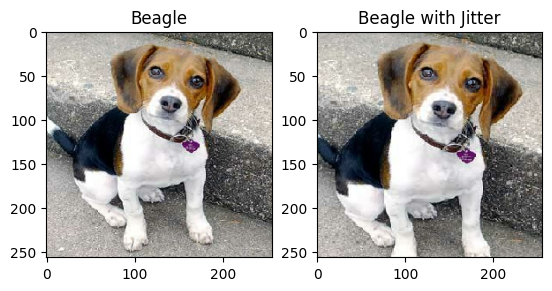

In [25]:
sample_beagle = next(iter(train_beagles))

plt.subplot(121)
plt.title('Beagle')
plt.imshow(sample_beagle[0] * 0.5 + 0.5)


plt.subplot(122)
plt.title('Beagle with Jitter')
plt.imshow(random_jitter(sample_beagle[0]) * 0.5 + 0.5)

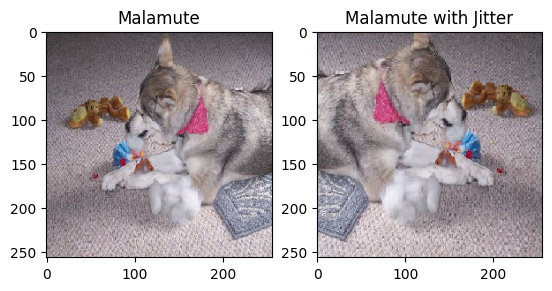

In [26]:
sample_malamute = next(iter(train_malamutes))

plt.subplot(121)
plt.title('Malamute')
plt.imshow(sample_malamute[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Malamute with Jitter')
plt.imshow(random_jitter(sample_malamute[0]) * 0.5 + 0.5)

## Import and Reuse Pix2Pix Models

In [27]:
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type=NORM_TYPE)
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type=NORM_TYPE)

discriminator_x = pix2pix.discriminator(norm_type=NORM_TYPE, target=False)
discriminator_y = pix2pix.discriminator(norm_type=NORM_TYPE, target=False)

## Loss Functions

In [28]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [29]:
# Initialize Optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [30]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# Restore the latest checkpoint if it exists.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

## Training

In [31]:
@tf.function
def train_step(real_x, real_y):
    # Persistent is set to True because the tape is used more than once
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # Same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [32]:
def generate_images(model, test_input):
    prediction = model(test_input)

    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

# As of 0630 on 01-Dec-22: 250 epochs completed (50 checkpoints after running one test epoch)

EPOCHS = 1

for epoch in range(EPOCHS):
    start_time = time.time()
    
    # Loop through every picture in both datasets
    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_beagles, train_malamutes)):
        train_step(image_x, image_y)
        if n % 2 == 0:
            print('.', end='')
        n += 1
        
    clear_output(wait=True)
    # Use a consistent image (sample_beagle) so that the progress of the model is apparent
    generate_images(generator_g, sample_beagle)

    # Save a checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

    print ('Time taken for epoch {} was {} sec\n'.format(epoch + 1,
                                                      time.time()-start_time))


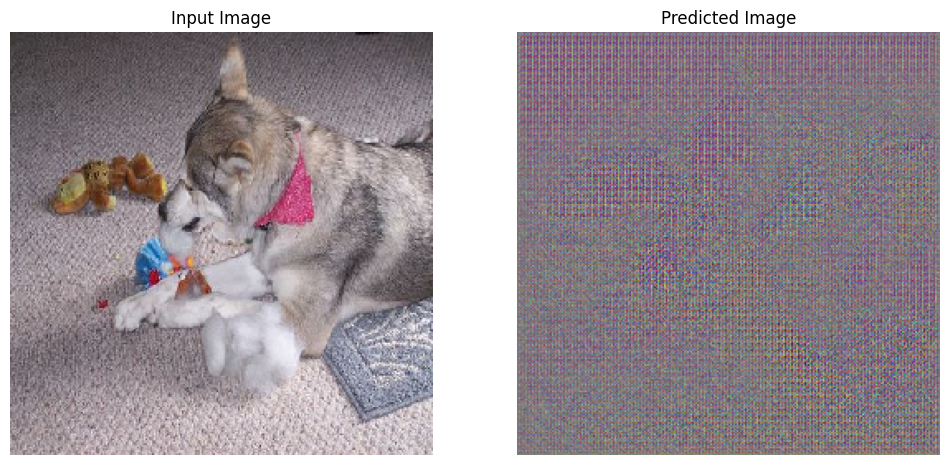

In [33]:
generate_images(generator_f, sample_malamute)

## Generate Images Using Test Data

In [34]:
# Run the trained model on the test dataset
for beagle in test_beagles.take(2):
    generate_images(generator_g, beagle)

for malamute in test_malamutes.take(2):
    generate_images(generator_f, malamute)

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node DecodeJpeg}}]] [Op:IteratorGetNext] name: 

### Malamute to Beagle or Beagle to Malamute?

In [ ]:
def generate_new(button):
    user_choice = user_selection.value
    
    # TODO: insert code from above once fixed

In [ ]:
user_selection = widgets.RadioButtons(
    options=[('Malamute -> Beagle', 1), ('Beagle -> Malamute', 2)],
    value=1,
    description='Choose: ',
    disabled=False
)

generate_button = widgets.Button(
    description='Generate',
    disabled=False,
    tooltip='Click to Generate'
)
generate_button.on_click(generate_new)

display(user_selection, generate_button)